# Results Markov

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())
import math
import copy
import gc

import src.ml.markov as mk
from src.dao.experiments_dao import load_execution_test_data_by_model, json_to_dataframe
import matplotlib.pyplot as plt
from src.exceptions import exceptions

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt

working dir /home/tales/dev/master/mdc_analysis


## Loading data

In [2]:
def round_up_list(num_list):
    rounded = [math.ceil(i) for i in num_list]
    return rounded

def hits_contain(df):
    df = copy.deepcopy(df)
    df["hits_contain"] = df["partial_hits"].apply(lambda lista : round_up_list(lista))
    df["hits_contain_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(round_up_list(lista)).mean())
    return df

def json_to_dataframe(json_list, simple_cols=True):
    df = pd.DataFrame(json_list)
    
    df["iteration"] = df["iteration"].astype(str)
    df["k"] = df["k"].astype(str)
    
    df["acc"] = df["total_hits"] / df["test_size"]
    
    df["partial_hits_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(lista).mean())
    
    df_markov = df[df["algorithm"] == "markov"]
    df_rest = df[df["algorithm"] != "markov"]
    
    df_markov = hits_contain(df_markov)
    
    df = df_markov.append(df_rest)
    
    df_markov = None
    df_rest = None
    
    gc.collect()
    
    if simple_cols:
        del df["states_not_trained_as_origin"]
        del df["hits"]
        del df["misses"]
        
    return df

In [3]:
results_dir = "clusters"

mk_results = load_execution_test_data_by_model(results_dir)
print("{} tests".format(len(mk_results)))

r = json_to_dataframe(mk_results, simple_cols=False)

r_dummy = r[r["is_dummy"] == True]
r = r[r["is_dummy"] == False]

r.sample(4)

2535 tests


,acc,algorithm,cluster_version,hits,hits_contain,hits_contain_mean,input_data_version,is_distributive,is_dummy,iteration,...,partial_hits_mean,states_not_trained_as_origin,test_id,test_size,total_hits,total_misses,total_states_not_trained_as_origin,train_size,trained_with,user_id
899,0.471,markov,each_one_by_itself,"[['finance'], ['WORK'], ['restaurant'], ['WORK...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.477,0.1.categ_v1_filtered_30min,False,False,1,...,0.477,[],20f5aaca-887d-43a8-ae32-b791eada7546,87,41,45,0,87,cluster,6031
2433,0.050,markov,all_vs_one,"[['cafe'], ['bar'], ['health'], ['lodging'], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.050,0.1.categ_v1,False,False,2,...,0.050,[],6aed0a80-7626-4132-ae3e-8b0dc817b170,303,15,287,0,44555,cluster,5972
2297,0.036,markov,all_vs_one,"[['restaurant'], ['health']]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.037,0.1.categ_v1_filtered_30min,False,False,0,...,0.037,[],800b7f82-b852-493c-9ca6-a4c7f8321d73,55,2,52,0,22671,cluster,6045
449,0.264,markov,all_vs_early_birds,"[['HOME'], ['restaurant'], ['HOME'], ['HOME'],...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.264,0.1.categ_v1_filtered_30min,False,False,1,...,0.264,[],51a7e006-b729-4feb-9151-2110ef6ab422,573,151,421,0,22153,cluster,5938


## Summary

In [4]:
try:
    r["pred_choice_method"] = r["pred_choice_method"].fillna("na")    
except KeyError:
    r["pred_choice_method"] = "na"
    
try:
    r["depth"] = r["depth"].fillna("na")
except KeyError:
    r["depth"] = "na"

In [5]:
r["input_data_version"].value_counts()

0.1.categ_v1                   1290
0.1.categ_v1_filtered_30min    1245
Name: input_data_version, dtype: int64

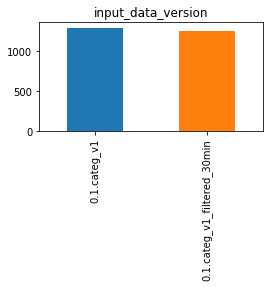

In [6]:
r["input_data_version"].value_counts().plot.bar(title="input_data_version", figsize=(4,2))

In [7]:
r["method"].value_counts()

cluster    2535
Name: method, dtype: int64

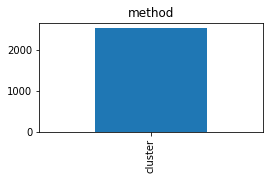

In [8]:
r["method"].value_counts().plot.bar(title="method", figsize=(4,2))

In [9]:
r["algorithm"].value_counts()

markov    2535
Name: algorithm, dtype: int64

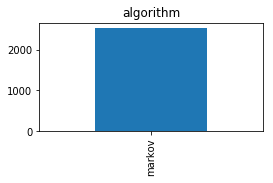

In [10]:
r["algorithm"].value_counts().plot.bar(title="algorithm", figsize=(4,2))

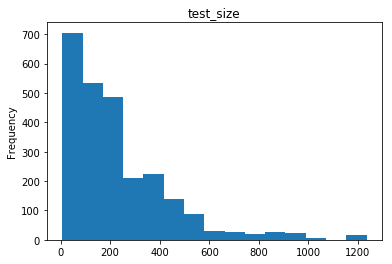

In [11]:
r["test_size"].plot.hist(title="test_size", bins=15)

## Accuracy

In [12]:
r.columns

Index(['acc', 'algorithm', 'cluster_version', 'hits', 'hits_contain',
       'hits_contain_mean', 'input_data_version', 'is_distributive',
       'is_dummy', 'iteration', 'k', 'method', 'misses', 'partial_hits',
       'partial_hits_mean', 'states_not_trained_as_origin', 'test_id',
       'test_size', 'total_hits', 'total_misses',
       'total_states_not_trained_as_origin', 'train_size', 'trained_with',
       'user_id', 'pred_choice_method', 'depth'],
      dtype='object')

In [13]:
def summary_results(use_results):
    summarized = []
    
    for algorithm in use_results["algorithm"].drop_duplicates():
        
        for method in use_results["method"].drop_duplicates():
            
            for input_data_version in use_results["input_data_version"].drop_duplicates():
                
                for pred_choice_method in use_results["pred_choice_method"].drop_duplicates():
                    
                    for depth in use_results["depth"].drop_duplicates():
                        
                        for cluster_version in use_results["cluster_version"].drop_duplicates():
                    
                            selection = use_results[(use_results["algorithm"] == algorithm) & 
                                                    (use_results["method"] == method) &
                                                    (use_results["input_data_version"] == input_data_version) &
                                                    (use_results["pred_choice_method"] == pred_choice_method) &
                                                    (use_results["depth"] == depth) &
                                                    (use_results["cluster_version"] == cluster_version)
                                                   ]

                            acc = selection["acc"].median()
                            mad = selection["acc"].mad()

                            summarized.append({"acc": acc, 
                                               "mad": mad,
                                               "algorithm": algorithm, 
                                               "method": method, 
                                               "pred_choice_method": pred_choice_method, 
                                               "input_data": input_data_version,
                                               "depth": depth,
                                               "cluster_version": cluster_version})

    
    return summarized

In [14]:
results_df = pd.DataFrame(summary_results(r))
results_df = results_df[~results_df["acc"].isna()]
results_df.reset_index()

,index,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method
0,0,0.196,markov,cluster_early_birds,na,0.1.categ_v1_filtered_30min,0.114,cluster,na
1,1,0.151,markov,cluster_tireless_its,na,0.1.categ_v1_filtered_30min,0.043,cluster,na
2,2,0.097,markov,all_vs_one,na,0.1.categ_v1_filtered_30min,0.050,cluster,na
3,3,0.113,markov,all_vs_tireless_its,na,0.1.categ_v1_filtered_30min,0.040,cluster,na
4,4,0.383,markov,each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.116,cluster,na
5,5,0.371,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.150,cluster,na
6,6,0.083,markov,all_vs_night_owls,na,0.1.categ_v1_filtered_30min,0.067,cluster,na
7,7,0.000,markov,cluster_night_owls,na,0.1.categ_v1_filtered_30min,0.054,cluster,na
8,8,0.138,markov,all_vs_early_birds,na,0.1.categ_v1_filtered_30min,0.069,cluster,na
9,9,0.115,markov,cluster_early_birds,na,0.1.categ_v1,0.044,cluster,na


In [57]:
results_df["id"] = results_df["cluster_version"] + " : " + results_df["input_data"]

In [58]:
# results_df["id"] = ["Markov - 0.0.categ_v1", 
#                     "Markov - 0.1.categ_v1",
#                     "CTW, depth:3, most_likely, 0.0.categ_v1",
#                     "CTW, depth:2, most_likely, 0.0.categ_v1",
#                     "CTW, depth:3, random_choice, 0.0.categ_v1",
#                     "CTW, depth:2, random_choice, 0.0.categ_v1",
#                     "CTW, depth:3, most_likely, 0.1.categ_v1",
#                     "CTW, depth:2, most_likely, 0.1.categ_v1",
#                     "CTW, depth:3, random_choice, 0.1.categ_v1",
#                     "CTW, depth:2, random_choice, 0.1.categ_v1"]

In [59]:
results_df.sort_values("acc", ascending=False)

,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method,id
4,0.383,markov,each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.116,cluster,na,each_one_by_itself : 0.1.categ_v1_filtered_30min
5,0.371,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.150,cluster,na,extreme_trav_each_one_by_itself : 0.1.categ_v1...
14,0.295,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1,0.127,cluster,na,extreme_trav_each_one_by_itself : 0.1.categ_v1
13,0.280,markov,each_one_by_itself,na,0.1.categ_v1,0.095,cluster,na,each_one_by_itself : 0.1.categ_v1
0,0.196,markov,cluster_early_birds,na,0.1.categ_v1_filtered_30min,0.114,cluster,na,cluster_early_birds : 0.1.categ_v1_filtered_30min
1,0.151,markov,cluster_tireless_its,na,0.1.categ_v1_filtered_30min,0.043,cluster,na,cluster_tireless_its : 0.1.categ_v1_filtered_3...
8,0.138,markov,all_vs_early_birds,na,0.1.categ_v1_filtered_30min,0.069,cluster,na,all_vs_early_birds : 0.1.categ_v1_filtered_30min
9,0.115,markov,cluster_early_birds,na,0.1.categ_v1,0.044,cluster,na,cluster_early_birds : 0.1.categ_v1
3,0.113,markov,all_vs_tireless_its,na,0.1.categ_v1_filtered_30min,0.040,cluster,na,all_vs_tireless_its : 0.1.categ_v1_filtered_30min
17,0.107,markov,all_vs_early_birds,na,0.1.categ_v1,0.023,cluster,na,all_vs_early_birds : 0.1.categ_v1


In [60]:
results_01_categ_30min = results_df[results_df["input_data"] == "0.1.categ_v1_filtered_30min"]

In [61]:
results_01_categ_05min = results_df[results_df["input_data"] == "0.1.categ_v1"]

# Accuracy - Single Partition

In [62]:
min_30 = ['all_vs_early_birds : 0.1.categ_v1_filtered_30min',
          'cluster_early_birds : 0.1.categ_v1_filtered_30min',
          
          'all_vs_night_owls : 0.1.categ_v1_filtered_30min',
          'cluster_night_owls : 0.1.categ_v1_filtered_30min',
          
          'all_vs_tireless_its : 0.1.categ_v1_filtered_30min',
          'cluster_tireless_its : 0.1.categ_v1_filtered_30min',
          
          'all_vs_one : 0.1.categ_v1_filtered_30min',
          'each_one_by_itself : 0.1.categ_v1_filtered_30min',
          'extreme_trav_each_one_by_itself : 0.1.categ_v1_filtered_30min']

min_05 = ['all_vs_early_birds : 0.1.categ_v1',
         'cluster_early_birds : 0.1.categ_v1',

         'all_vs_night_owls : 0.1.categ_v1',
         'cluster_night_owls : 0.1.categ_v1',

         'all_vs_tireless_its : 0.1.categ_v1',
         'cluster_tireless_its : 0.1.categ_v1',
         
         'all_vs_one : 0.1.categ_v1'
         'each_one_by_itself : 0.1.categ_v1',
         'extreme_trav_each_one_by_itself : 0.1.categ_v1']

## categ_v1

In [68]:
results_df.set_index("id").loc[min_05]

,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method
id,,,,,,,,
all_vs_early_birds : 0.1.categ_v1,0.107,markov,all_vs_early_birds,na,0.1.categ_v1,0.023,cluster,na
cluster_early_birds : 0.1.categ_v1,0.115,markov,cluster_early_birds,na,0.1.categ_v1,0.044,cluster,na
all_vs_night_owls : 0.1.categ_v1,0.069,markov,all_vs_night_owls,na,0.1.categ_v1,0.038,cluster,na
cluster_night_owls : 0.1.categ_v1,0.073,markov,cluster_night_owls,na,0.1.categ_v1,0.044,cluster,na
all_vs_tireless_its : 0.1.categ_v1,0.094,markov,all_vs_tireless_its,na,0.1.categ_v1,0.019,cluster,na
cluster_tireless_its : 0.1.categ_v1,0.103,markov,cluster_tireless_its,na,0.1.categ_v1,0.021,cluster,na
all_vs_one : 0.1.categ_v1each_one_by_itself : 0.1.categ_v1,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN
extreme_trav_each_one_by_itself : 0.1.categ_v1,0.295,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1,0.127,cluster,na


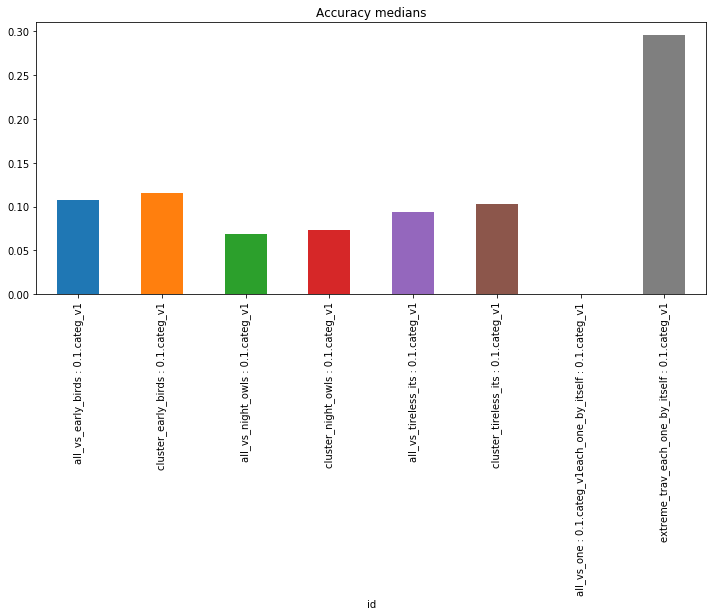

In [67]:
f, ax = plt.subplots(figsize=(12,5))
results_df.set_index("id").loc[min_05]["acc"].plot.bar(title="Accuracy medians Stop Region 5 min")

In [70]:
results_df.set_index("id").loc[min_30]

,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method
id,,,,,,,,
all_vs_early_birds : 0.1.categ_v1_filtered_30min,0.138,markov,all_vs_early_birds,na,0.1.categ_v1_filtered_30min,0.069,cluster,na
cluster_early_birds : 0.1.categ_v1_filtered_30min,0.196,markov,cluster_early_birds,na,0.1.categ_v1_filtered_30min,0.114,cluster,na
all_vs_night_owls : 0.1.categ_v1_filtered_30min,0.083,markov,all_vs_night_owls,na,0.1.categ_v1_filtered_30min,0.067,cluster,na
cluster_night_owls : 0.1.categ_v1_filtered_30min,0.000,markov,cluster_night_owls,na,0.1.categ_v1_filtered_30min,0.054,cluster,na
all_vs_tireless_its : 0.1.categ_v1_filtered_30min,0.113,markov,all_vs_tireless_its,na,0.1.categ_v1_filtered_30min,0.040,cluster,na
cluster_tireless_its : 0.1.categ_v1_filtered_30min,0.151,markov,cluster_tireless_its,na,0.1.categ_v1_filtered_30min,0.043,cluster,na
all_vs_one : 0.1.categ_v1_filtered_30min,0.097,markov,all_vs_one,na,0.1.categ_v1_filtered_30min,0.050,cluster,na
each_one_by_itself : 0.1.categ_v1_filtered_30min,0.383,markov,each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.116,cluster,na
extreme_trav_each_one_by_itself : 0.1.categ_v1_filtered_30min,0.371,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1_filtered_30min,0.150,cluster,na


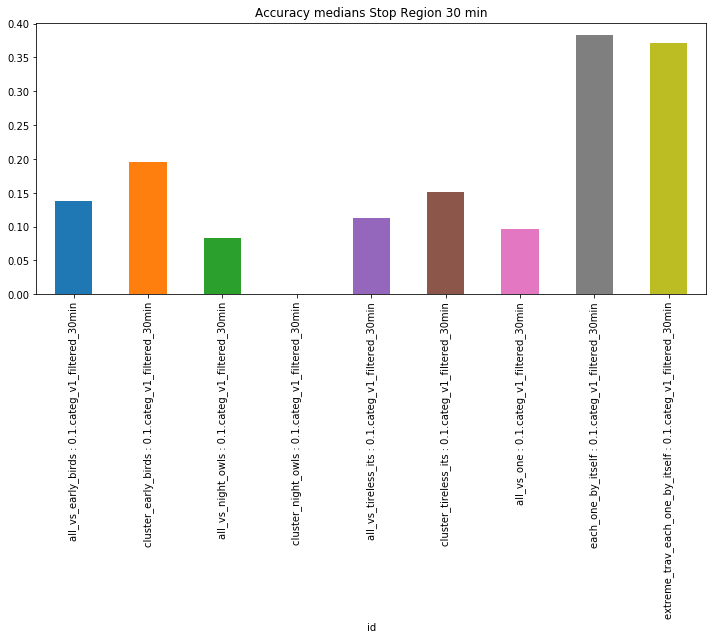

In [69]:
f, ax = plt.subplots(figsize=(12,5))
results_df.set_index("id").loc[min_30]["acc"].plot.bar(title="Accuracy medians Stop Region 30 min")

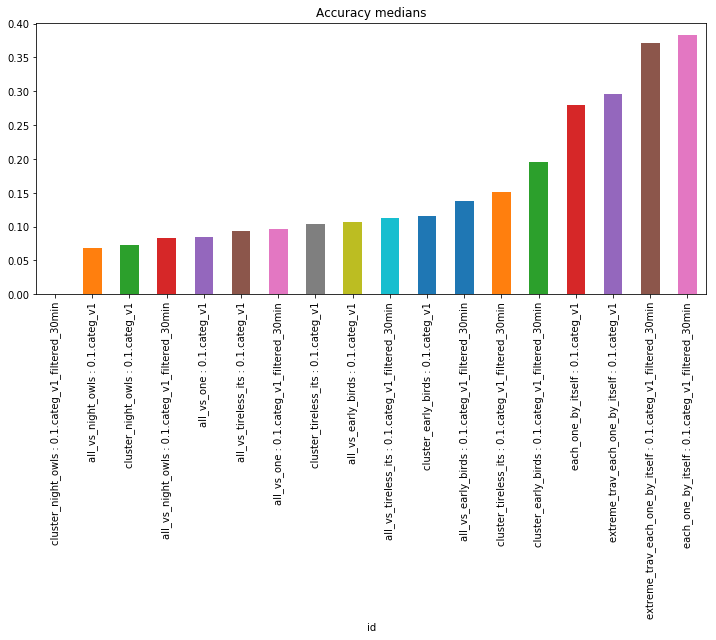

In [19]:
f, ax = plt.subplots(figsize=(12,5))
results_df.set_index("id").sort_values(["acc"])["acc"].plot.bar(title="Accuracy medians")

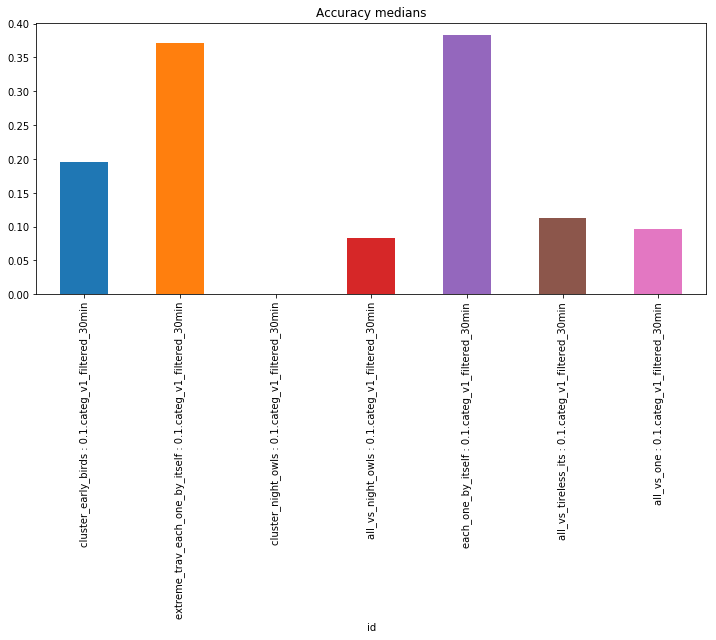

In [21]:
f, ax = plt.subplots(figsize=(12,5))
results_df.loc[[0,5,7,6,4,3,2]].set_index("id")["acc"].plot.bar(title="Accuracy medians")